In [ ]:
!pip install -q -U bitsandbytes datasets
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U trl

In [ ]:
from datasets import load_dataset
from datasets import Dataset
ds = load_dataset("vilm/OpenOrca-Viet",split="train[:10000]")
ds = ds.train_test_split(test_size=0.01)

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 9900
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 100
    })
})

In [ ]:
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer,GPTQConfig
from transformers import BitsAndBytesConfig
import torch
bnb_config = BitsAndBytesConfig(
    load_in_8bit= True,
    bnb_8bit_quant_type= "nf8",
    bnb_8bit_compute_dtype= torch.bfloat16,
    bnb_8bit_use_double_quant= False,
)
# HuggingFaceH4/zephyr-7b-beta
modelName = "HuggingFaceH4/zephyr-7b-beta" # Or whatever you want in HuggingFace
tokenizer = AutoTokenizer.from_pretrained(modelName)
model = AutoModelForCausalLM.from_pretrained(modelName,load_in_8bit=True,
                                             quantization_config=bnb_config,
                                              torch_dtype=torch.bfloat16,
                                              device_map="auto",
                                              trust_remote_code=True,)
model.config.use_cache = False # silence the warnings. Please re-enable for inference!
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()

# Load tokenizer
tokenizer.padding_side = 'right'
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True
tokenizer.add_bos_token, tokenizer.add_eos_token


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

(True, True)

In [ ]:
def text_formatting(data):
  messages = [
    {
        "role": "system",
        "content": data["instruction"],
    },
    {"role": "user", "content": data["input"]},
    {"role": "assistant", "content": data["output"]},
  ]
  data['chat_format'] = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
  # data['chat_format'] = f"""### Instruction:\n{data["instruction"]} \n\n### Input:\n{data["input"]}\n\n### Response:\n{data["output"]}"""
  return data

ds["train"] = ds["train"].map(text_formatting)
ds["test"] = ds["test"].map(text_formatting)

Map:   0%|          | 0/9900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
# # Tokenizer/Véc tơ hóa văn bản (Chuyển văn bản thành số để training)
# def tokeni(example):
#     example["chat_format_token"] = tokenizer(example["chat_format"], return_tensors='pt',
#                                              padding=True,truncation=True,
#                                              max_length=512)['input_ids']
#     return example
# # Map function trên vào dataset
# ds["train"] = ds["train"].map(tokeni,batched=True)
# ds["test"] = ds["test"].map(tokeni,batched=True)

In [ ]:
print(ds["train"]["chat_format"][5])

<|system|>
Bạn nên mô tả nhiệm vụ và giải thích câu trả lời của bạn. Trong khi trả lời câu hỏi trắc nghiệm, trước tiên hãy xuất (các) câu trả lời đúng. Sau đó giải thích tại sao các câu trả lời khác là sai. Hãy suy nghĩ như bạn đang trả lời một đứa trẻ năm tuổi.</s>
<|user|>
Nếu chính tại Fontainebleau, ông đã thoái vị vào năm 1814 để đi lưu vong lần đầu trên đảo Elba., liệu chúng ta có thể kết luận rằng" Ông đến đảo Elba vào năm 1814." ?
 TÙY CHỌN:
 Tôi. Đúng.
 thứ hai. nó là không thể nói.
 iii. KHÔNG.</s>
<|assistant|>
Tôi. Đúng.

 Chúng ta có thể kết luận rằng" Ông đến đảo Elba năm 1814" bởi vì ông đã thoái vị vào năm 1814 tại Fontainebleau để đi lưu vong lần đầu tiên trên đảo Elba. Điều này có nghĩa là anh ta rời bỏ vị trí quyền lực của mình và đến sống trên đảo Elba vào năm đó. Các tùy chọn khác là sai vì chúng tôi có đủ thông tin từ tuyên bố để biết khi nào anh ấy đến Elba.</s>
<|assistant|>



In [ ]:
# Hàm tính số lượng parameters có thể train được trên model
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
# Set config for LoRA
from peft import LoraConfig, get_peft_model,prepare_model_for_kbit_training
model_lora = prepare_model_for_kbit_training(model)
config = LoraConfig(
      r=8, #attention heads
      lora_alpha=16, #alpha scaling
      lora_dropout=0.05,
      bias="none",
      task_type="CAUSAL_LM",
      target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
)
# Set peft adapter to model
model_lora = get_peft_model(model_lora, config)
print_trainable_parameters(model_lora)

trainable params: 20971520 || all params: 7262703616 || trainable%: 0.2887563792882719


In [ ]:
import transformers
from transformers import Trainer,EarlyStoppingCallback,TrainingArguments
from trl import SFTTrainer

#Hyperparamter
training_arguments = TrainingArguments(
      per_device_train_batch_size=24, # batch size
      num_train_epochs=1, # epochs
      gradient_accumulation_steps=2,
      warmup_steps=100,
      save_total_limit=5,
      learning_rate=2e-4,
      fp16=True,
      output_dir='outputs',
      logging_steps=20,
      evaluation_strategy="steps",
      load_best_model_at_end = True,
      )
# Setting sft parameters
trainer = SFTTrainer(
    model=model_lora,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    peft_config=config,
    max_seq_length= 512,
    dataset_text_field="chat_format",
    tokenizer=tokenizer,
    args=training_arguments,
    packing= False,
)

Map:   0%|          | 0/9900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
trainer.evaluate()

{'eval_loss': 1.401771903038025,
 'eval_runtime': 22.103,
 'eval_samples_per_second': 4.524,
 'eval_steps_per_second': 0.588}

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
20,1.303700,1.217747
40,1.138100,1.109197
60,1.059600,1.051466
80,1.000100,1.018697
100,0.981800,0.999559
120,0.969100,0.979828
140,0.937100,0.960450
160,0.922000,0.946430
180,0.902600,0.937765
200,0.886600,0.929353


TrainOutput(global_step=206, training_loss=1.00651806072124, metrics={'train_runtime': 8607.8904, 'train_samples_per_second': 1.15, 'train_steps_per_second': 0.024, 'total_flos': 2.1662998554319258e+17, 'train_loss': 1.00651806072124, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


{'eval_loss': 0.9291833639144897,
 'eval_runtime': 21.8265,
 'eval_samples_per_second': 4.582,
 'eval_steps_per_second': 0.596,
 'epoch': 1.0}

<function matplotlib.pyplot.show(close=None, block=None)>

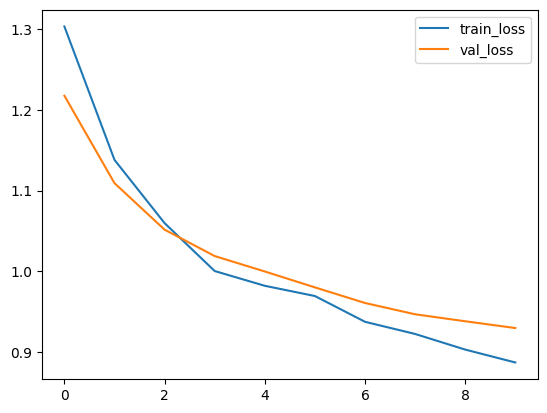

In [ ]:
trainingEpoch_loss_adam,validationEpoch_loss_adam=[],[]
t = 0
for i in trainer.state.log_history[:-1]:
   if t == 0:
     trainingEpoch_loss_adam.append(i["loss"])
     t=1
   else:
     validationEpoch_loss_adam.append(i["eval_loss"])
     t=0
from matplotlib import pyplot as plt
plt.plot(trainingEpoch_loss_adam, label='train_loss')
plt.plot(validationEpoch_loss_adam,label='val_loss')
plt.legend()
plt.show

In [ ]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
import torch
from transformers import pipeline, TextStreamer
from peft import PeftConfig, PeftModel
messages = [
    {
        "role": "system",
        "content": "Bạn là một trợ lý AI giúp mọi người tìm kiếm thông tin.",
    },
    {"role": "user", "content": "Ai là người đầu tiên lên mặt trăng?"},
]
prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = tokenizer( prompt, return_tensors="pt")
streamer = TextStreamer(tokenizer)
with torch.autocast(device.type):
  outputs = model_lora.generate(input_ids=inputs["input_ids"].to(device),
                                streamer=streamer,
                                max_new_tokens=50,
                                no_repeat_ngram_size=2,
                                num_beams=1,
                                num_return_sequences=1)
  # print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0])

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


<s> <|system|>
Bạn là một trợ lý AI giúp mọi người tìm kiếm thông tin.</s> 
<|user|>
Ai là người đầu tiên lên mặt trăng?</s> 

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



<|assistant|>
</s><s> 1. Neil Armstrong

Neil Alden Armstong (1930-2012) là nhà hàng khôi nguyên của chuyến bay 


In [ ]:
!huggingface-cli login --token=<mytoken>

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/.cache/huggingface/token
Login successful


In [ ]:
model_name = "vietzephyr-7b-lora-8bit"
HUGGING_FACE_USER_NAME="phatjk"
model_lora.push_to_hub(f"{HUGGING_FACE_USER_NAME}/{model_name}", use_auth_token=True)
tokenizer.push_to_hub(f"{HUGGING_FACE_USER_NAME}/{model_name}", use_auth_token=True)

CommitInfo(commit_url='https://huggingface.co/phatjk/vietzephyr-7b-lora-8bit/commit/0f2956c8d9f2953250dadbcfd310e6070b63ba98', commit_message='Upload tokenizer', commit_description='', oid='0f2956c8d9f2953250dadbcfd310e6070b63ba98', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
model_path = "phatjk/vietzephyr-7b-lora-8bit"
config = PeftConfig.from_pretrained(model_path)
model_2 = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    load_in_8bit=True,
    device_map='auto'
)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
qa_model = PeftModel.from_pretrained(model_2, model_path)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/83.9M [00:00<?, ?B/s]

In [ ]:
from transformers import pipeline, TextStreamer
messages = [
    {
        "role": "system",
        "content": "Bạn là một trợ lý AI giúp mọi người tìm kiếm thông tin.",
    },
    {"role": "user", "content": "Ai là người đầu tiên lên mặt trăng?"},
]
prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = tokenizer( prompt, return_tensors="pt")
streamer = TextStreamer(tokenizer)
with torch.cuda.amp.autocast():
    output_tokens = qa_model.generate(**inputs,streamer=streamer, max_new_tokens=100)

<s> <|system|>
Bạn là một trợ lý AI giúp mọi người tìm kiếm thông tin.</s> 
<|user|>
Ai là người đầu tiên lên mặt trăng?</s> 
<|assistant|>


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1636: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


Người đầu tiên lên mặt trăng là Neil Armstrong, người đã điều hành và điều hành Apollo 11, một chuyến bay không quân của Liên minh Hàn lâm vào ngày 20 tháng 7 năm
